# Histogram of Oriented Gradient (HOG):

### Import Python Modules:

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# for scikit-learn <= 0.17 use:
# from sklearn.cross_validation import train_test_split

### Import vehicle  and non-vehicle data images:

In [2]:
cars = []
notcars = []

# Read in our vehicles and non-vehicles
cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non_vehicles/**/*.png')

print('Number of vehicle data: ', len(cars))
print('Number of not-vehicle data: ', len(notcars))

Number of vehicle data:  8792
Number of not-vehicle data:  8968


### Visualize the data:

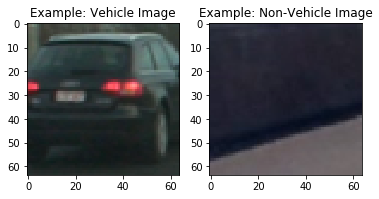

In [3]:
n = np.random.randint(0, len(cars))

car_image = mpimg.imread(cars[n])
notcar_image = mpimg.imread(notcars[n])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example: Vehicle Image')
plt.subplot(122)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example: Non-Vehicle Image')
plt.show()

### Histogram of Oriented Gradients (HOG):

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Bin Spatial:

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Color Histogram:

In [6]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Import an image and get HOG features from it:

In [7]:
# Read in the image
image = car_image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


C:\Users\LENOVO\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Display image and HOG features:

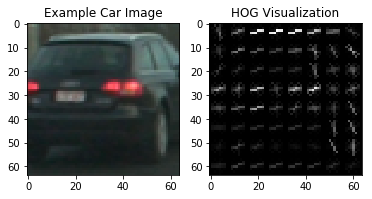

In [8]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

### Extract features from all the training vehicle images:

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

### Take limited sample of data for training:

In [10]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
# sample_size = 5000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# If you want to train for all images,
cars = cars
notcars = notcars

# Take randomized samples
# n_samples = 1000
# random_indx = np.random.randint(0, len(cars), n_samples)
# cars = np.array(cars)[random_indx]
# notcars = np.array(notcars)[random_indx]

### Parameters for HOG:

In [11]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

orient = 9         # HOG orientations
pix_per_cell = 8   # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16          # Number of histogram bins

spatial_feat = True # Spatial features on or off
hist_feat = True    # Histogram features on or off
hog_feat = True     # HOG features on or off

y_start_stop = [400, 700] # Min and max in y to search in slide_window()

### Extract vehicle and non-vehicle features:

In [12]:
t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
feature_extraction_time = round(t2-t, 2)

C:\Users\LENOVO\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


163.04 Seconds to extract HOG features...


### Data preparation: Features

In [13]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

with open('./Model/X_scaler_with_color_features.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)

### Data preparation: Labels

In [14]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Split data for training and testing:

In [15]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

### Feature Vector Length:

In [16]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


### Create a classifier and train it:

In [17]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
training_time = round(t2-t, 2)

with open('./Model/svc_model_with_color_features.pkl', 'wb') as f:
    pickle.dump(svc, f)

print('Trained model saved to the directory')    

215.19 Seconds to train SVC...
Trained model saved to the directory


### Accuracy:

In [18]:
# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', accuracy)

Test Accuracy of SVC =  0.9879


### Prediction:

In [19]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
1.31257 Seconds to predict 10 labels with SVC
